# W266 Final Project Notebook 
This notebook produces the DistilBERT and BERT classifiers for my project~

In [1]:
!pip install transformers --quiet

     |████████████████████████████████| 2.2MB 6.3MB/s 
     |████████████████████████████████| 870kB 20.8MB/s 
     |████████████████████████████████| 3.3MB 39.7MB/s 


In [2]:
!pip install tensorflow_text --quiet

     |████████████████████████████████| 3.4MB 6.6MB/s 


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ast
import os
import re
from tensorflow.keras import regularizers
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
from transformers import AutoTokenizer,TFAutoModel,DistilBertConfig,TFDistilBertForSequenceClassification,TFDistilBertModel
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding,GlobalMaxPooling1D,concatenate,Bidirectional,LSTM


In [4]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.114.20.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.114.20.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = "/content/drive/MyDrive/w266/cleaned_data.csv"
data = pd.read_csv(path)

In [7]:
data.head()

,name,date,platform,score,summary,url,userscore,fullurl,developer,genre,user_reviews,critic_reviews
0,Tony Hawk's Pro Skater 2,"September 20, 2000",PlayStation,98,As most major publishers' development efforts ...,/game/playstation/tony-hawks-pro-skater-2,7.4,https://www.metacritic.com/game/playstation/to...,Neversoft Entertainment,"['Sports', 'Alternative', 'Skateboarding']","[""Breath-taking, still replayable to this day....",['The best skateboarding game ever and one of ...
1,Tony Hawk's Pro Skater 2,"November 6, 2000",Dreamcast,97,"Hawk's back - with new technology, new pros an...",/game/dreamcast/tony-hawks-pro-skater-2,6.1,https://www.metacritic.com/game/dreamcast/tony...,Treyarch,"['Sports', 'Alternative', 'Skateboarding']","[""Now this game was what I remember being the ...","[""There's enough skaters, objectives, levels, ..."
2,Perfect Dark,"May 22, 2000",Nintendo 64,97,Step into the Dark... As Carrington Institute'...,/game/nintendo-64/perfect-dark,8.8,https://www.metacritic.com/game/nintendo-64/pe...,Rare Ltd.,"['Action', 'Shooter', 'First-Person', 'Sci-Fi']","[""I bought Perfect Dark the day it was release...","[""It's a stunning achievement by any measure a..."
3,NFL 2K1,"September 7, 2000",Dreamcast,97,"In the end, NFL 2K1 is a deeper, more refined ...",/game/dreamcast/nfl-2k1,6.4,https://www.metacritic.com/game/dreamcast/nfl-2k1,Visual Concepts,"['Sports', 'Traditional', 'Football', 'Sim']",['This game still holds its own after four yea...,"[""Not only is this the first console game that..."
4,Baldur's Gate II: Shadows of Amn,"September 24, 2000",PC,95,An epic continuation of the story that began i...,/game/pc/baldurs-gate-ii-shadows-of-amn,9.1,https://www.metacritic.com/game/pc/baldurs-gat...,BioWare,"['Role-Playing', 'PC-style RPG', 'PC-style RPG...",['Quite possibly the best game ever made! A de...,"[""It's not just vast, but flooded with quests ..."


In [9]:
data['critic_reviews'] = data['critic_reviews'].apply(lambda x:np.array(ast.literal_eval(x)))
data["user_reviews"] = data["user_reviews"].apply(lambda y:np.array(ast.literal_eval(y)))
data = data[data["userscore"]!="tbd"]
data['userscore'] = 10*data["userscore"].astype('float')
data["target"] = (data["score"]-data["userscore"])
data["binary_target"] = data["target"].apply(lambda x: 1 if x>=0 else 0)

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# bert = TFAutoModel.from_pretrained("bert-base-cased")

In [14]:
def combine_reviews(df,n_reviews):
    copy = df.copy()
    np.random.seed(0)
    copy["critic_reviews"] = copy["critic_reviews"].apply(lambda x: np.random.choice(x,n_reviews,replace=False) if len(x)>= n_reviews else x)
    copy["critic_reviews"] = copy["critic_reviews"].apply(lambda y: " ".join(y))
    copy["critic_reviews"] = copy["critic_reviews"].apply(clean_text)
    copy["user_reviews"] = (copy["user_reviews"]
                          .apply(lambda x: np.random.choice(x,n_reviews,replace=False) if len(x)>= n_reviews else x))
    copy["user_reviews"] = copy["user_reviews"].apply(lambda y: " ".join(y))
    copy["user_reviews"] = copy["user_reviews"].apply(clean_text)
    return copy
def clean_text(w):
    w = re.sub(r'[^\x00-\x7f]',r'', w)
    #w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=re.sub(r'@\w+', '',w)
    return w
data = combine_reviews(data,7)

In [16]:
def tokenize_example(example_critic_review,example_user_review):
  tokenized_critic = tokenizer.encode_plus(example_critic_review,add_special_tokens = True,max_length=MAX_LENGTH,padding='max_length',return_attention_mask = True,return_tensors='tf',truncation=True)
  tokenized_user = tokenizer.encode_plus(example_user_review,add_special_tokens = True,max_length=MAX_LENGTH,padding='max_length',return_attention_mask = True,return_tensors='tf',truncation=True)
  input_ids = np.array([tokenized_critic["input_ids"],tokenized_user["input_ids"]])
  attention_masks = np.array([tokenized_critic["attention_mask"],tokenized_user["attention_mask"]])
  return input_ids,attention_masks


In [17]:
MAX_LENGTH=512
critic_input_ids=[]
critic_attention_masks=[]

user_input_ids=[]
user_attention_masks=[]


for a,b in zip(data['critic_reviews'],data["user_reviews"]):
    critic_inps=tokenizer.encode_plus(a,add_special_tokens = True,max_length=MAX_LENGTH,padding='max_length',return_attention_mask = True,return_tensors='tf',truncation=True)
    critic_input_ids.append(tf.reshape(critic_inps['input_ids'], [-1]))
    critic_attention_masks.append(tf.reshape(critic_inps['attention_mask'], [-1]))
    user_inps=tokenizer.encode_plus(b,add_special_tokens = True,max_length=MAX_LENGTH,padding='max_length',return_attention_mask = True,return_tensors='tf',truncation=True)
    user_input_ids.append(tf.reshape(user_inps['input_ids'], [-1]))
    user_attention_masks.append(tf.reshape(user_inps['attention_mask'], [-1]))
    
labels=data["binary_target"].to_numpy()

In [19]:
numSentences = len(critic_input_ids)
np.random.seed(0)
training_examples = np.random.binomial(1, 0.7, numSentences)

critic_trainSentence_ids = []
critic_trainMasks = []

critic_testSentence_ids = []
critic_testMasks = []

user_trainSentence_ids = []
user_trainMasks = []

user_testSentence_ids = []
user_testMasks = []

labels_train =[]
labels_test = []


for example in range(numSentences):
    if training_examples[example] == 1:
        critic_trainSentence_ids.append(critic_input_ids[example])
        critic_trainMasks.append(critic_attention_masks[example])
        user_trainSentence_ids.append(user_input_ids[example])
        user_trainMasks.append(user_attention_masks[example])
        labels_train.append(labels[example])
    else:
        critic_testSentence_ids.append(critic_input_ids[example])
        critic_testMasks.append(critic_attention_masks[example])
        user_testSentence_ids.append(user_input_ids[example])
        user_testMasks.append(user_attention_masks[example])
        labels_test.append(labels[example])
        
X_train = np.array([critic_trainSentence_ids,user_trainSentence_ids,critic_trainMasks,user_trainMasks])
X_test = np.array([critic_testSentence_ids,user_testSentence_ids,critic_testMasks,user_testMasks])

y_train = np.array(labels_train)
y_test = np.array(labels_test)

In [34]:
def create_distilbert_model(max_length):
    critic_Sentence_ids = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="critic_input_ids")
    critic_Masks = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="critic_input_masks")
    
    
    critic_bert_inputs = [critic_Sentence_ids,critic_Masks]

    user_Sentence_ids = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="user_input_ids")
    user_Masks = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="user_input_masks")
    
    
    user_bert_inputs = [user_Sentence_ids,user_Masks]

    
    
  
    kernel_size=3
    config = DistilBertConfig(num_labels=2)
    config.output_hidden_states = False
    bert=TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config) 
    
    
    critic_bert_sequence = bert(critic_bert_inputs)[0]
    user_bert_sequence = bert(user_bert_inputs)[0]
    
    critic_lstm = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(critic_bert_sequence)
    user_lstm = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(user_bert_sequence)
  
    combined = concatenate([critic_lstm,user_lstm])
  
    X = tf.keras.layers.GlobalMaxPool1D()(combined)
    X = tf.keras.layers.Dense(50, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(X) 
    model = tf.keras.Model(inputs=[critic_Sentence_ids,user_Sentence_ids,critic_Masks,user_Masks], outputs=y)

    return model

In [37]:
with strategy.scope():
  config = DistilBertConfig(num_labels=2)
  config.output_hidden_states = False
  distilbert_model=create_distilbert_model(MAX_LENGTH)
  distilbert_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryAccuracy('accuracy')])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Let us check the shape of the critic BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 512, 768), dtype=tf.float32, name=None), name='tf_distil_bert_model_2/distilbert/transformer/layer_._5/output_layer_norm/batchnorm/add_1:0', description="created by layer 'tf_distil_bert_model_2'")
Let us check the shape of the user BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 512, 768), dtype=tf.float32, name=None), name='tf_distil_bert_model_2/distilbert/transformer/layer_._5/output_layer_norm/batchnorm/add_1:0', description="created by layer 'tf_distil_bert_model_2'")


In [ ]:
distilbert_history = distilbert_model.fit(
    [X_train[0], X_train[1],X_train[2],X_train[3]],
    y_train,
    epochs=10,
    batch_size=64
)


In [23]:
def create_confusion_matrix(model,title):
  y_pred = np.array([np.round(p) for p in model.predict([X_test[0],X_test[1],X_test[2],X_test[3]])]).reshape(-1)
  c = confusion_matrix(y_pred,y_test)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  c.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      c.flatten()/np.sum(c)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(c ,annot=labels,fmt='')
  plt.title(title);
  return plt.show()

In [ ]:
create_confusion_matrix(distilbert_model,"DistilBERT LSTM")

In [ ]:
def create_bert_model_lstm(max_length):
    critic_Sentence_ids = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="critic_input_ids")
    critic_Masks = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="critic_input_masks")
    
    
    critic_bert_inputs = [critic_Sentence_ids,critic_Masks]

    user_Sentence_ids = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="user_input_ids")
    user_Masks = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="user_input_masks")
    
    
    user_bert_inputs = [user_Sentence_ids,user_Masks]

    
    
  
    kernel_size=3
    bert = TFAutoModel.from_pretrained("bert-base-cased") 
    
    
    critic_bert_sequence = bert(critic_bert_inputs)[0]
    user_bert_sequence = bert(user_bert_inputs)[0]
    
    critic_lstm = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(critic_bert_sequence)
    user_lstm = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(user_bert_sequence)
      
    combined = concatenate([critic_lstm,user_lstm])
    
    X = tf.keras.layers.GlobalMaxPool1D()(combined)
    X = tf.keras.layers.Dense(50, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(X) 
    model = tf.keras.Model(inputs=[critic_Sentence_ids,user_Sentence_ids,critic_Masks,user_Masks], outputs=y)
    model.layers[2].trainable = False
    model.summary()
    return model

In [ ]:
with strategy.scope():
  lstm_bert_model=create_bert_model_lstm(MAX_LENGTH)
  lstm_bert_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryAccuracy('accuracy')])

In [ ]:
lstm_bert_history = lstm_bert_model.fit(
    [X_train[0], X_train[1],X_train[2],X_train[3]],
    y_train,
    epochs=5,
    batch_size=32
)


In [24]:
def create_bert_model_cnn(max_length):
    critic_Sentence_ids = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="critic_input_ids")
    critic_Masks = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="critic_input_masks")
    
    
    critic_bert_inputs = [critic_Sentence_ids,critic_Masks]

    user_Sentence_ids = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="user_input_ids")
    user_Masks = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="user_input_masks")
    
    
    user_bert_inputs = [user_Sentence_ids,user_Masks]

    
    
  
    kernel_size=3
    bert = TFAutoModel.from_pretrained("bert-base-cased") 

    critic_bert_sequence = bert(critic_bert_inputs)[0]
    user_bert_sequence = bert(user_bert_inputs)[0]
    print('Let us check the shape of the critic BERT layer output:', critic_bert_sequence)
    print('Let us check the shape of the user BERT layer output:', user_bert_sequence)
    critic_conv = Convolution1D(128,kernel_size,kernel_initializer='he_normal',activation="relu")(critic_bert_sequence)
    user_conv = Convolution1D(128,kernel_size,kernel_initializer='he_normal',activation="relu")(user_bert_sequence)
  
    critic_pooled = tf.keras.layers.MaxPooling1D(5)(critic_conv)  
    user_pooled = tf.keras.layers.MaxPooling1D(5)(user_conv)  
    combined = concatenate([critic_conv,user_conv])
    X = tf.keras.layers.GlobalMaxPool1D()(combined)
    X = tf.keras.layers.Dense(50, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(X) 
    model = tf.keras.Model(inputs=[critic_Sentence_ids,user_Sentence_ids,critic_Masks,user_Masks], outputs=y)
    
    return model

In [29]:
with strategy.scope():
  cnn_bert_model=create_bert_model_cnn(MAX_LENGTH)
  cnn_bert_model.compile(optimizer=tf.keras.optimizers.Adam(2e-5),loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryAccuracy('accuracy')])

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Let us check the shape of the critic BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 512, 768), dtype=tf.float32, name=None), name='tf_bert_model_1/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_bert_model_1'")
Let us check the shape of the user BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 512, 768), dtype=tf.float32, name=None), name='tf_bert_model_1/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_bert_model_1'")


In [30]:
cnn_bert_history = cnn_bert_model.fit(
    [X_train[0], X_train[1],X_train[2],X_train[3]],
    y_train,
    epochs=5,
    batch_size=32
)


Epoch 1/5


329/329 [==============================] - 267s 447ms/step - loss: 0.6765 - accuracy: 0.6008
Epoch 2/5
329/329 [==============================] - 81s 246ms/step - loss: 0.5674 - accuracy: 0.7054
Epoch 3/5
329/329 [==============================] - 81s 247ms/step - loss: 0.5002 - accuracy: 0.7570
Epoch 4/5
329/329 [==============================] - 81s 247ms/step - loss: 0.3924 - accuracy: 0.8281
Epoch 5/5
329/329 [==============================] - 81s 247ms/step - loss: 0.2364 - accuracy: 0.9083


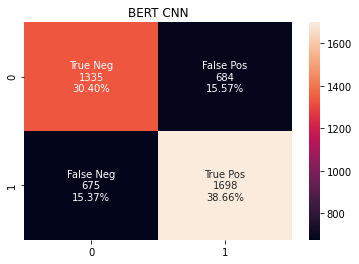

In [31]:
create_confusion_matrix(cnn_bert_model, "BERT CNN")

In [33]:
results = cnn_bert_model.evaluate([X_test[0],X_test[1],X_test[2],X_test[3]], y_test)

138/138 [==============================] - 12s 85ms/step - loss: 0.7707 - accuracy: 0.6906


In [17]:
def create_distilbert_model_cnn(max_length):
    critic_Sentence_ids = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="critic_input_ids")
    critic_Masks = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="critic_input_masks")
    
    
    critic_bert_inputs = [critic_Sentence_ids,critic_Masks]

    user_Sentence_ids = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="user_input_ids")
    user_Masks = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="user_input_masks")
    
    
    user_bert_inputs = [user_Sentence_ids,user_Masks]

    
    
  
    kernel_size=3
    
    
    config = DistilBertConfig(num_labels=2)
    config.output_hidden_states = False
    bert=TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config) 

    critic_bert_sequence = bert(critic_bert_inputs)[0]
    user_bert_sequence = bert(user_bert_inputs)[0]
    print('Let us check the shape of the critic BERT layer output:', critic_bert_sequence)
    print('Let us check the shape of the user BERT layer output:', user_bert_sequence)
    critic_conv = Convolution1D(128,kernel_size,kernel_initializer='he_normal',activation="relu")(critic_bert_sequence)
    user_conv = Convolution1D(128,kernel_size,kernel_initializer='he_normal',activation="relu")(user_bert_sequence)

    critic_pooled = tf.keras.layers.MaxPooling1D(5)(critic_conv)  
    user_pooled = tf.keras.layers.MaxPooling1D(5)(user_conv)  
    combined = concatenate([critic_conv,user_conv])
    
    X = tf.keras.layers.GlobalMaxPool1D()(combined)
    X = tf.keras.layers.Dense(50, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(X) 
    model = tf.keras.Model(inputs=[critic_Sentence_ids,user_Sentence_ids,critic_Masks,user_Masks], outputs=y)
    model.summary()
    return model

In [18]:
with strategy.scope():
  config = DistilBertConfig(num_labels=2)
  config.output_hidden_states = False
  cnn_distilbert_model=create_distilbert_model_cnn(MAX_LENGTH)
  cnn_distilbert_model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryAccuracy('accuracy')])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Let us check the shape of the critic BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 512, 768), dtype=tf.float32, name=None), name='tf_distil_bert_model/distilbert/transformer/layer_._5/output_layer_norm/batchnorm/add_1:0', description="created by layer 'tf_distil_bert_model'")
Let us check the shape of the user BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 512, 768), dtype=tf.float32, name=None), name='tf_distil_bert_model/distilbert/transformer/layer_._5/output_layer_norm/batchnorm/add_1:0', description="created by layer 'tf_distil_bert_model'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
critic_input_ids (InputLayer)   [(None, 512)]        0                                            
__________________________________________________________________________________________________

In [19]:
cnn_distilbert_history = cnn_distilbert_model.fit(
    [X_train[0], X_train[1],X_train[2],X_train[3]],
    y_train,
    epochs=5,
    batch_size=64
)

Epoch 1/5


165/165 [==============================] - 142s 449ms/step - loss: 0.7648 - accuracy: 0.5294
Epoch 2/5
165/165 [==============================] - 37s 226ms/step - loss: 0.6887 - accuracy: 0.5575
Epoch 3/5
165/165 [==============================] - 37s 227ms/step - loss: 0.6762 - accuracy: 0.5834
Epoch 4/5
165/165 [==============================] - 40s 241ms/step - loss: 0.6717 - accuracy: 0.5867
Epoch 5/5
165/165 [==============================] - 37s 226ms/step - loss: 0.6707 - accuracy: 0.5859


In [ ]:
results = cnn_distilbert_model.evaluate([X_test[0],X_test[1],X_test[2],X_test[3]], y_test)

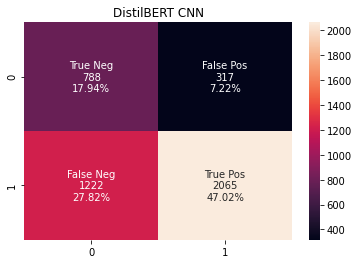

In [85]:
create_confusion_matrix(cnn_distilbert_model,"DistilBERT CNN")